<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Spankys Pizzeria](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.04-Spankys-Pizzeria.ipynb) | [Contents](toc.ipynb) | [Geometric Brownian Price Process](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.06-Geometric-Brownian-Price-Process.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.05-Warehouse-Fulfillment-Operations.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Warehouse Fulfullment Operations

This notebook demonstrates use of the [SimPy](http://simpy.readthedocs.org/en/latest/) to simulate the order fulfillment operations of a hypothetical warehouse.

## Order Fulfillment Model

http://kevingue.wordpress.com/2012/02/13/discrete-time-modeling-for-order-picking/

### Order Processing

The order fulfillment operation is a sequence of eight events

1. Order sent to the fulfillment center.
1. Picker requested for the order.
1. Order picked from the warehouse.
1. Picker released.
1. Inspector requested to review the order prior to shipping.
1. Order reviewed.
1. Reviewer released.
1. Order shipped.

### Order Generator

`orderGenerator` creates a sequence of orders following a Poisson distribution at an average rate 1/T_ORDER. Each order is tagged with a unique name using `itertools.count()`.

### Event Logging

Events are logged and stored in a dictionary attached to an instance of the fulfillment class. The keys are an (orderId,event) tuple with the time stamp stored as the value. The raw data trace can be accessed as the `._data` field, or as a pandas Dataframe in the `.log` field.

### Fulfillment Class

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import random
import simpy
import itertools
import pandas as pd
from IPython.core.display import display, HTML

# Global variables
T_ORDER = 10                      # average time between orders (Poisson)
T_PICK = 15                       # mean time to pick order from warehouse (beta)
T_REVIEW = 2                      # mean time to review order prior to shipment (beta)
T_SHIP_MIN = 8; T_SHIP_MAX = 12   # mean time to ship order (uniform)
ALPHA = 2.0; BETA = 5.0           # beta distribution parameters

# Global defaults
T_SIM = 1440               # simulation period
N_PICKER = 2               # number of product pickers
N_REVIEWER = 1             # number of product reviewers



class fulfillment(object):
    def __init__(self, n_picker=N_PICKER, n_reviewer=N_REVIEWER):
        self.env = simpy.Environment()
        self._data = dict()
        self.picker = simpy.Resource(self.env,n_picker)
        self.reviewer = simpy.Resource(self.env,n_reviewer)
        self.env.process(self.orderGenerator())
        
    def writeLog(self,orderId,event):
        self._data[orderId,event] = self.env.now
        
    @property
    def log(self):
        df = pd.DataFrame([[a,b,self._data[a,b]] for (a,b) in self._data.keys()])      
        df = df.pivot(index=0,columns=1,values=2).reset_index()
        return df[list(df.columns)[1:]] 
    
    @property
    def stats(self):
        tdelta = pd.DataFrame()
        for c in self.log.columns:
            tdelta[c] = self.log[c] - self.log['Ordered']
        return pd.DataFrame([tdelta.mean(),tdelta.std()],index=['mean','std'])
        
    def order(self,orderId):
        self.writeLog(orderId,'Ordered')
        with self.picker.request() as preq:
            yield preq
            self.writeLog(orderId,'Pick Assigned')
            yield self.env.timeout(T_PICK*((ALPHA+BETA)/ALPHA)*random.betavariate(ALPHA,BETA))
            self.writeLog(orderId,'Picked')
            self.picker.release(preq)
        with self.reviewer.request() as rreq:
            yield rreq
            self.writeLog(orderId,'Review Assigned')
            yield self.env.timeout(T_REVIEW*((ALPHA+BETA)/ALPHA)*random.betavariate(ALPHA,BETA))
            self.writeLog(orderId,'Reviewed')
            self.reviewer.release(rreq)
                
        yield self.env.timeout(random.uniform(T_SHIP_MIN,T_SHIP_MAX))
        self.writeLog(orderId,'Shipped')
                
    def orderGenerator(self):
        for orderId in itertools.count():
            yield self.env.timeout(random.expovariate(1.0/T_ORDER))
            self.env.process(self.order(orderId))
             
    def run(self,t_sim = T_SIM):
        self.env.run(until=t_sim)

### Simulation

1,Ordered,Pick Assigned,Picked,Review Assigned,Reviewed,Shipped
0,7.229992,7.229992,11.739807,11.739807,15.226160,25.083620
1,15.197544,15.197544,18.556609,18.556609,19.667813,29.122926
2,25.125070,25.125070,27.794269,27.794269,31.321191,41.420071
3,31.641760,31.641760,35.951135,35.951135,37.746525,49.240719
4,55.818810,55.818810,76.585644,76.585644,78.323934,88.024557


Elapsed Time from Order Placement


,Ordered,Pick Assigned,Picked,Review Assigned,Reviewed,Shipped
mean,0.0,14.006331,29.228007,29.405602,31.449083,41.502859
std,0.0,18.272545,20.163448,20.145527,20.217277,20.208458


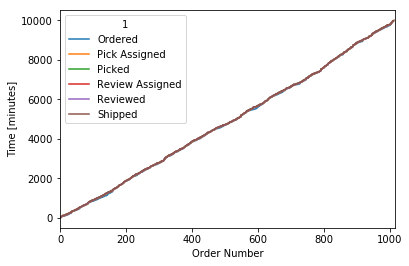

In [2]:
# create an order fulfillment instance
w = fulfillment(n_picker = 2, n_reviewer = 1)

# run a simulation for a specified period
w.run(10000)

# verify simulation log
display(w.log.head())

print("Elapsed Time from Order Placement")
display(w.stats)

# plot log results
w.log.plot()
plt.xlabel('Order Number')
plt.ylabel('Time [minutes]')

## Analyzing Results

### Total Processing Time

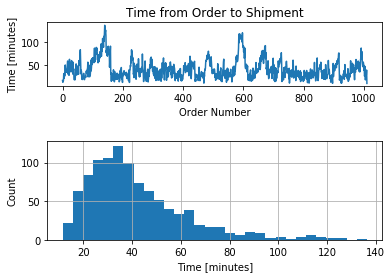

In [3]:
torder = w.log['Shipped'] - w.log['Ordered']
plt.subplot(3,1,1)
plt.plot(torder)
plt.xlabel('Order Number')
plt.ylabel('Time [minutes]')
plt.title('Time from Order to Shipment')

plt.subplot(2,1,2)
torder.hist(bins=30)
plt.xlabel('Time [minutes]')
plt.ylabel('Count')

### Time to Assign Picker

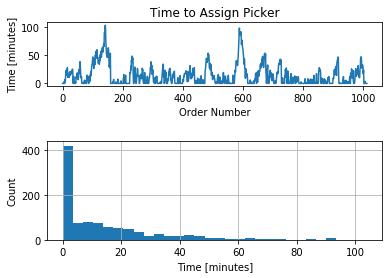

In [4]:
twait = w.log['Pick Assigned'] - w.log['Ordered']
plt.subplot(3,1,1)
plt.plot(twait)
plt.xlabel('Order Number')
plt.ylabel('Time [minutes]')
plt.title('Time to Assign Picker')

plt.subplot(2,1,2)
twait.hist(bins=30)
plt.xlabel('Time [minutes]')
plt.ylabel('Count')

### Time to Pick Order

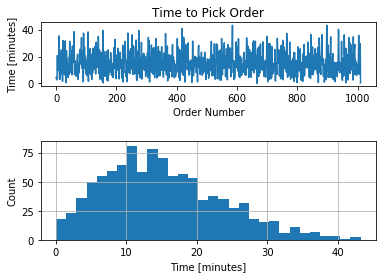

In [5]:
tpick = w.log['Picked'] - w.log['Pick Assigned']
plt.subplot(3,1,1)
plt.plot(tpick)
plt.xlabel('Order Number')
plt.ylabel('Time [minutes]')
plt.title('Time to Pick Order')

plt.subplot(2,1,2)
tpick.hist(bins=30)
plt.xlabel('Time [minutes]')
plt.ylabel('Count')

### Time to Assign Reviewer

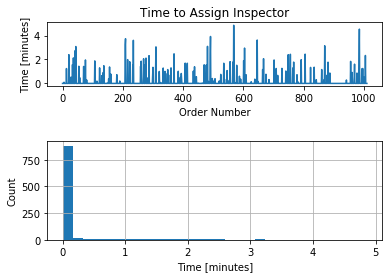

In [6]:
twait = w.log['Review Assigned'] - w.log['Picked']
plt.subplot(3,1,1)
plt.plot(twait)
plt.xlabel('Order Number')
plt.ylabel('Time [minutes]')
plt.title('Time to Assign Inspector')

plt.subplot(2,1,2)
twait.hist(bins=30)
plt.xlabel('Time [minutes]')
plt.ylabel('Count')

### Time to Review Order

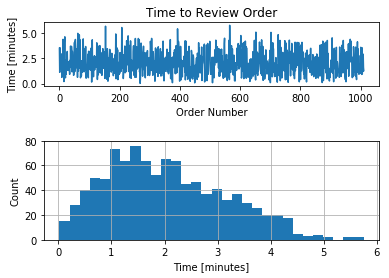

In [7]:
treview = w.log['Reviewed'] - w.log['Review Assigned']
plt.subplot(3,1,1)
plt.plot(treview)
plt.xlabel('Order Number')
plt.ylabel('Time [minutes]')
plt.title('Time to Review Order')

plt.subplot(2,1,2)
treview.hist(bins=30)
plt.xlabel('Time [minutes]')
plt.ylabel('Count')

### Time to Ship

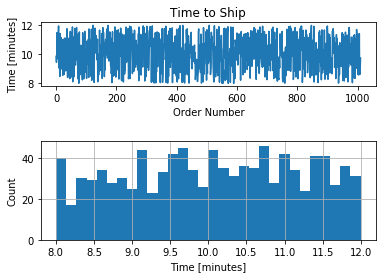

In [8]:
tship = w.log['Shipped'] - w.log['Reviewed']
plt.subplot(3,1,1)
plt.plot(tship)
plt.xlabel('Order Number')
plt.ylabel('Time [minutes]')
plt.title('Time to Ship')

plt.subplot(2,1,2)
tship.hist(bins=30)
plt.xlabel('Time [minutes]')
plt.ylabel('Count')

<!--NAVIGATION-->
< [Spankys Pizzeria](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.04-Spankys-Pizzeria.ipynb) | [Contents](toc.ipynb) | [Geometric Brownian Price Process](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.06-Geometric-Brownian-Price-Process.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.05-Warehouse-Fulfillment-Operations.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>